<center> <h1>The CAPM and investment styles</h1> </center>

<center>William Mann</center>

<center>
<img src="https://wgjm1986.github.io/FIN323/Emory_small.png" height="200px" width="300px" />
</center>                                                                                            

In [1]:
%%capture

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import wrds
import fredapi
import math
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16.0, 8.0]
from scipy.optimize import minimize

import statsmodels.formula.api as sm

import os
from dotenv import load_dotenv
load_dotenv();

## From portfolio theory to the CAPM

Portfolio theory tells us what a mean-variance investor should do, given their predictions about μ, σ, and ρ.
The Capital Asset Pricing Model (CAPM) asks what would happen, if all investors actually followed this advice, and made the same forecasts:
- With the same forecasts, they choose the same risky portfolio.
- The only portfolio they can all choose is the market portfolio.
- So, it must in fact have the highest possible Sharpe ratio.
- Then all investments have zero α with respect to it.
- More precisely, the best *prediction* of α is always zero.  
We will always find investments with nonzero α in past data.  
But the CAPM says you could not have picked them in advance.

## The Capital Asset Pricing Model (CAPM)

Conclusion: The best prediction about every investment is that

$$
\mathbb{E}[r_i − r_f ] = \beta_{im} × \mathbb{E}[r_m − r_f ]
$$

This appears similar to our earlier formula, but says much more:
- Portfolio theory says what an individual should do, but does not make any predictions about what will actually happen.
- The CAPM does: It predicts that all investments have zero α.
If some investment had a positive α, then all investors should try
to buy it, and prices should simply adjust until that α disappears.
- In other words, the CAPM describes an equilibrium.

## The CAPM uses ideas from portfolio theory

The logic behind the CAPM formula is really just portfolio theory,
applied to the case of an investor who holds the market portfolio:
- $\beta_{im}$ is a (rescaled) correlation with the market portfolio.
It is also the slope of the best-fit line from regressing $r_i$ on $r_m$.
- $\alpha_{im}$ measures whether investment i beats its hurdle rate.
It is also the intercept of the same best-fit regression line.
- Suppose we start from the market portfolio and add more of i.  
$\beta_{im} \lessgtr 1$ tells us whether portfolio volatility grows or shrinks,  
$\alpha_{im} \lessgtr 0$ tells us whether portfolio Sharpe ratio grows or shrinks.

Again, the new thing is the prediction that $\alpha_{im}$ is always zero.

This also means $IR_{im} = 0$, so indexing is the best strategy.

## The market portfolio in theory and in practice

- The CAPM gives a special role to the “market portfolio,” which theoretically includes *every* risky investment.

- To use the CAPM, we need to measure the market portfolio’s return, in order to estimate $\beta_{im}$. This is clearly a difficult task.

- Most investment in the US is allocated to the stock market, and the average stock investor holds a value-weighted portfolio.

- So, *in practice,* people typically represent the market portfolio with a large, value-weighted portfolio of US stocks.

- Be aware that this is a big simplification of the theory. The “true” market portfolio would include not only stocks, but also corporate bonds, real estate, commodities, etc...

## What does market risk look like?

Here’s a view of the market portfolio, as it is usually measured:
This figure plots monthly returns on the VFINX index fund.

Loading library list...
Done


<Axes: xlabel='month'>

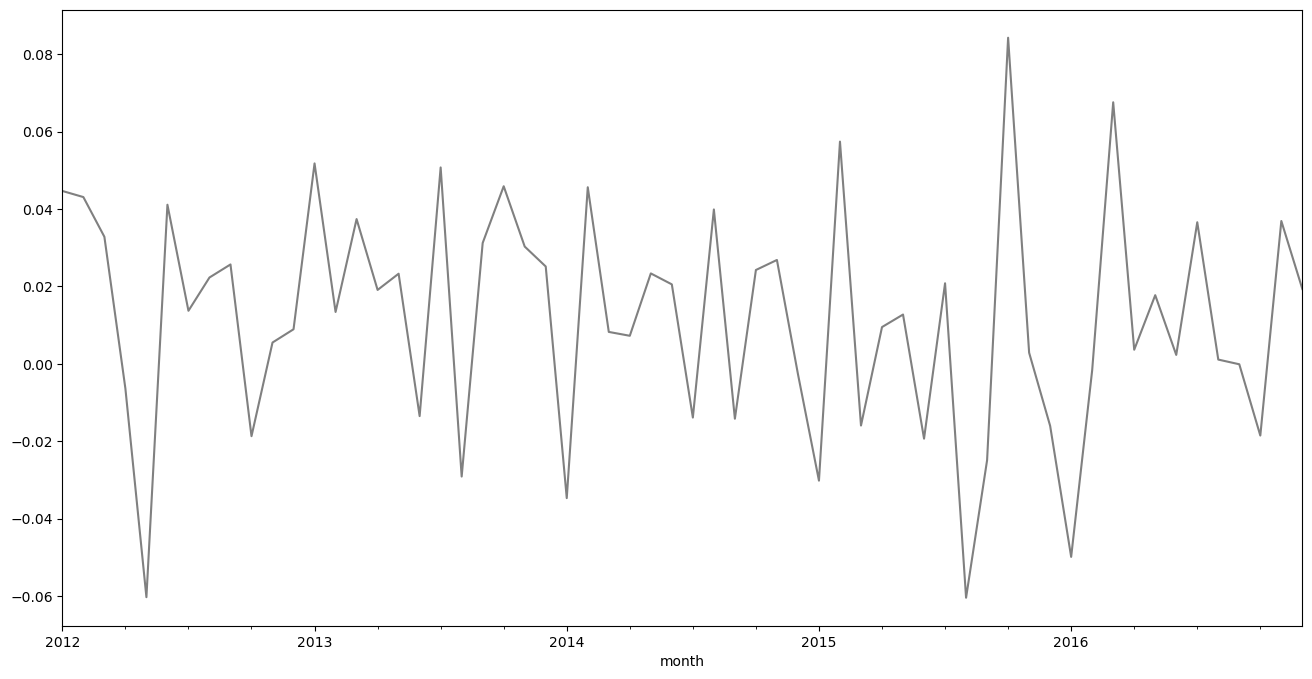

In [2]:
conn = wrds.Connection(wrds_username=os.environ['WRDS_USERNAME'])

FF3F = conn.get_table(library='ff_all',table='factors_monthly')
FF3F['month'] = pd.to_datetime(FF3F['date']).dt.to_period('M')
FF3F = FF3F.drop('date',axis=1).drop('dateff',axis=1).set_index('month')
riskfree = FF3F.rf.astype('float64')
riskfree = riskfree['2012':'2016']

VFINX_crsp_fundno = conn.raw_sql("select crsp_fundno, ticker from crsp_q_mutualfunds.fund_hdr where ticker = 'VFINX'").reset_index().crsp_fundno[0]
VFINX = conn.raw_sql("select caldt, mret from crsp_q_mutualfunds.monthly_returns where crsp_fundno = " + str(VFINX_crsp_fundno))
# Convert string date to datetime
VFINX = VFINX.set_index( pd.to_datetime(VFINX.set_index('caldt').index) ).drop('caldt',axis=1)
# Aggregate to monthly level
VFINX['month'] = VFINX.index.to_period('M')
VFINX = (VFINX.set_index('month') + 1).groupby('month').prod() - 1
VFINX.columns = ['VFINX']

conn.close()

VFINX_excess = VFINX['VFINX']['2012':'2016'] - pd.DataFrame(riskfree['2012':'2016'])['rf']
VFINX_fig,ax = plt.subplots()
VFINX_excess.plot(ax=ax,color='gray')

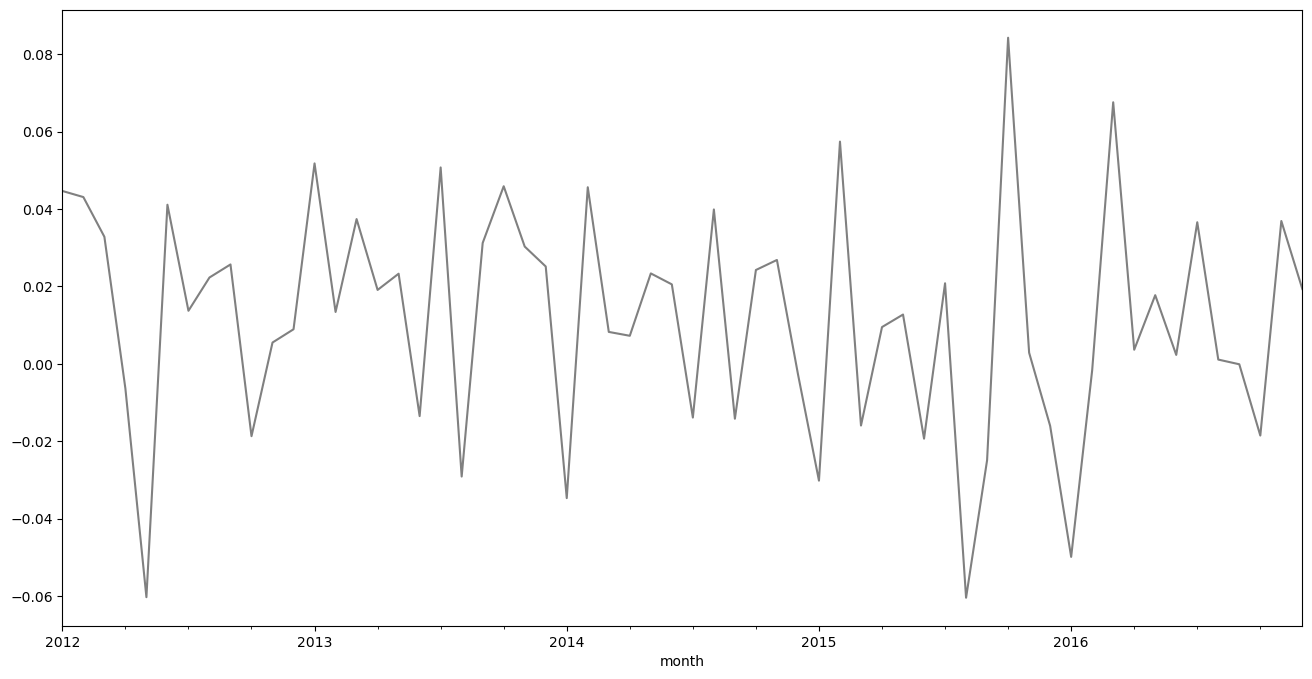

In [3]:
VFINX_fig

## What does market risk look like?

Add in the return of an ETF of retail stocks, with dividends reinvested. Its monthly return has 3% volatility and a market $\beta$ of 1.09.

In [4]:
%%capture

conn = wrds.Connection(wrds_username=os.environ['WRDS_USERNAME'])
XRT_crsp_fundno = conn.raw_sql("select crsp_fundno, ticker from crsp_q_mutualfunds.fund_hdr where ticker = 'XRT'").reset_index().crsp_fundno[0]
XRT = conn.raw_sql("select caldt, mret from crsp_q_mutualfunds.monthly_returns where crsp_fundno = " + str(XRT_crsp_fundno))
conn.close()

# Convert string date to datetime
XRT = XRT.set_index( pd.to_datetime(XRT.set_index('caldt').index) ).drop('caldt',axis=1)
# Aggregate to monthly level
XRT['month'] = XRT.index.to_period('M')
XRT = (XRT.set_index('month') + 1).groupby('month').prod() - 1
XRT.columns = ['XRT']

XRT_excess = XRT['XRT']['2012':'2016'] - pd.DataFrame(riskfree['2012':'2016'])['rf']
VFINX_XRT_fig,ax = plt.subplots()
VFINX_excess['2012':'2016'].plot(ax=ax,color='gray')
XRT_excess['2012':'2016'].plot(ax=ax,color='blue')

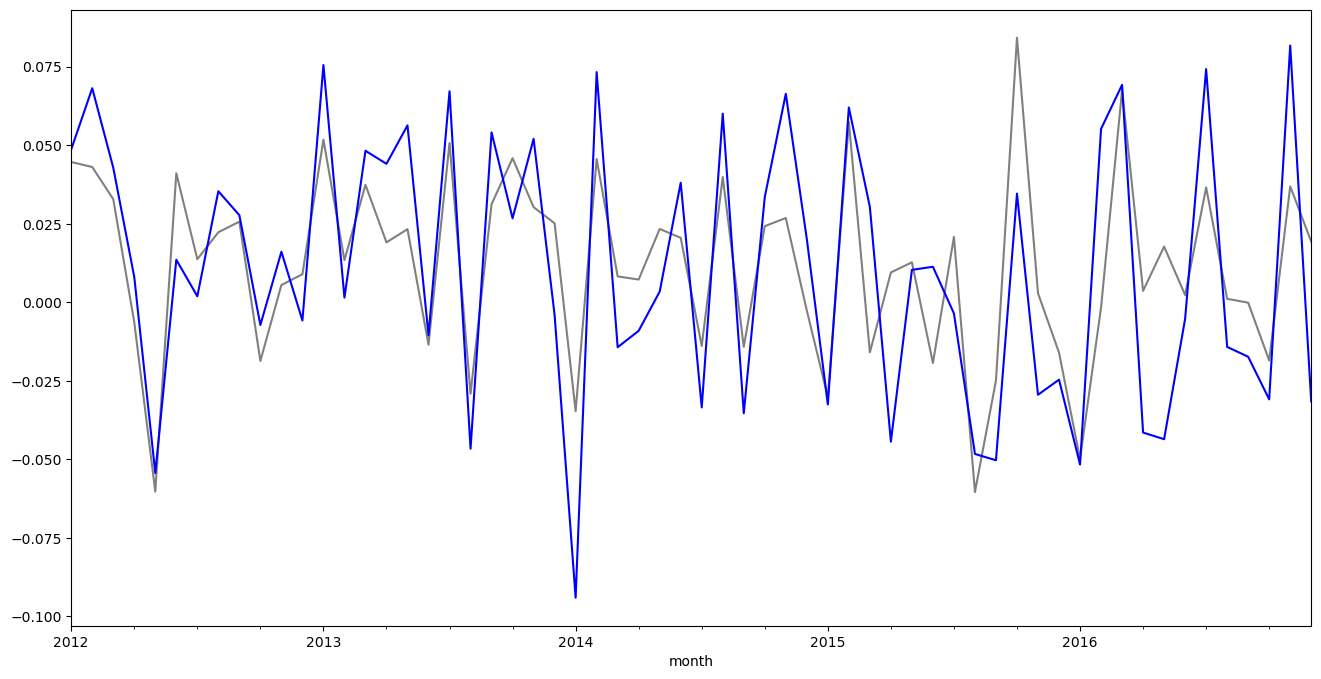

In [5]:
VFINX_XRT_fig

## What does market risk look like?

Replace the retail ETF with a gold ETF.
This ETF's monthly return has 5% volatility, but a beta of only 0.09.

In [6]:
%%capture
conn = wrds.Connection(wrds_username=os.environ['WRDS_USERNAME'])
GLD_crsp_fundno = conn.raw_sql("select crsp_fundno, ticker from crsp_q_mutualfunds.fund_hdr where ticker = 'GLD'").reset_index().crsp_fundno[0]
GLD = conn.raw_sql("select caldt, mret from crsp_q_mutualfunds.monthly_returns where crsp_fundno = " + str(GLD_crsp_fundno))
conn.close()
# Convert string date to datetime
GLD = GLD.set_index( pd.to_datetime(GLD.set_index('caldt').index) ).drop('caldt',axis=1)
# Aggregate to monthly level
GLD['month'] = GLD.index.to_period('M')
GLD = (GLD.set_index('month') + 1).groupby('month').prod() - 1
GLD.columns = ['GLD']

GLD_excess = GLD['GLD']['2012':'2016'] - pd.DataFrame(riskfree['2012':'2016'])['rf']
VFINX_GLD_fig,ax = plt.subplots()
VFINX_excess['2012':'2016'].plot(ax=ax,color='gray')
GLD_excess['2012':'2016'].plot(ax=ax,color='blue')

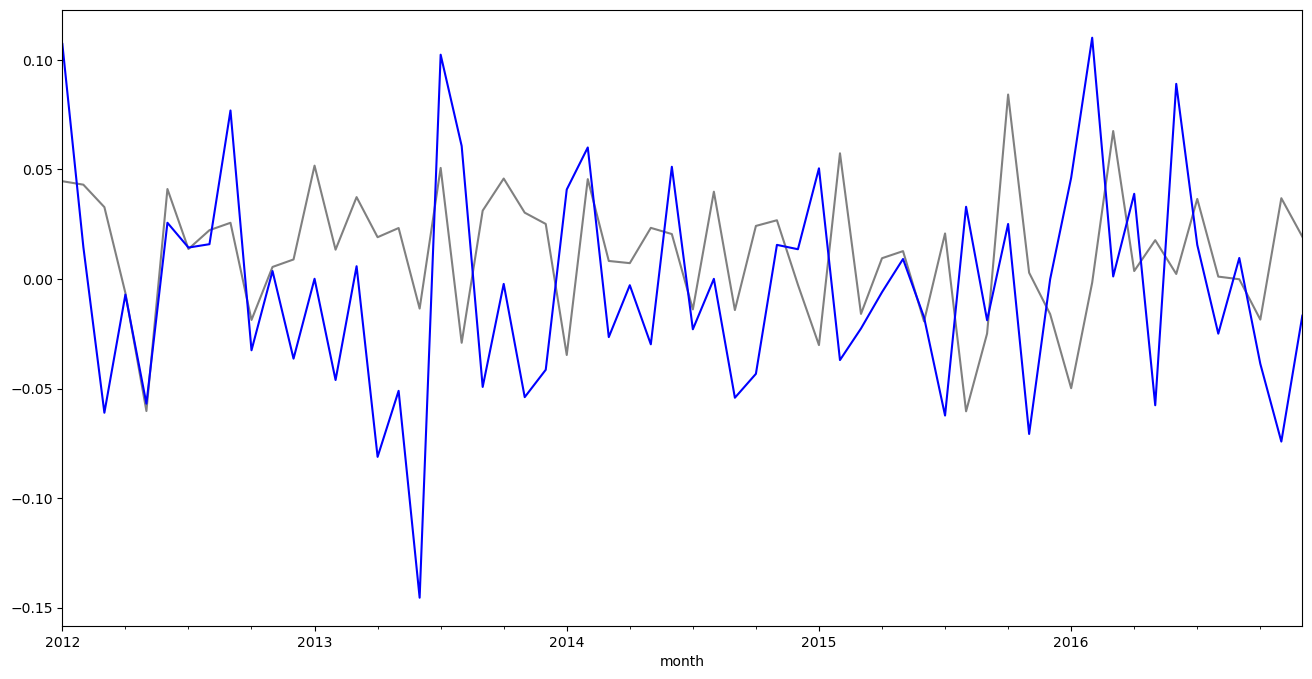

In [7]:
VFINX_GLD_fig

## What does market risk look like?

Here’s a different view of the same data on the retail ETF return:  
β is the slope of the best-fit line in the figure. Here, β = 1.09.

In [8]:
%%capture

# Define function to compactly estimate a best-fit line
def best_fit(y,x):
    from statsmodels.api import add_constant
    from statsmodels.regression.linear_model import OLS
    params = list( OLS(y,add_constant(x),hasconst=True).fit().params )
    alpha = params[0]
    beta = params[1]
    return alpha,beta

In [9]:
%%capture

# Generate new figure
XRT_VFINX_scatter,ax = plt.subplots()
# Scatter plot returns
plt.scatter(VFINX_excess['2012':'2016'],XRT_excess['2012':'2016'])
# Add best-fit line
alpha,beta = best_fit(XRT_excess['2012':'2016'],VFINX_excess['2012':'2016'])
ax.axline([0,alpha],[1,alpha+beta],color='orange')
# Add axes
ax.axline([0,0],[1,0],color='black',linewidth=0.5)
ax.axline([0,0],[0,1],color='black',linewidth=0.5)
# Set range of axes
ax.set_xlim([-0.15,0.15])
ax.set_ylim([-0.15,0.15])

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

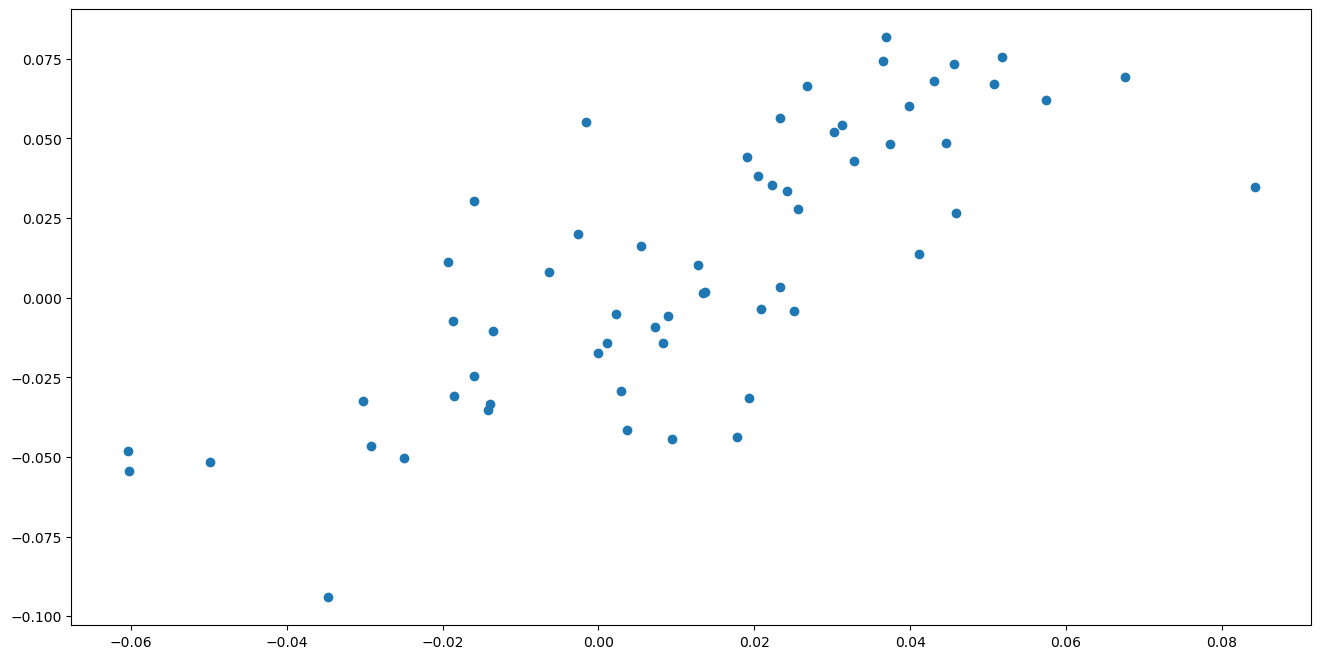

In [10]:
XRT_VFINX_scatter

## What does market risk look like?

A similar figure using the gold ETF:  
The line here is almost flat, with slope (beta) of 0.09

In [11]:
%%capture

# Generate new figure
GLD_VFINX_scatter,ax = plt.subplots()
# Scatter plot returns
plt.scatter(VFINX_excess['2012':'2016'],GLD_excess['2012':'2016'])
# Add best-fit line
b,m = best_fit(GLD_excess['2012':'2016'],VFINX_excess['2012':'2016'])
ax.axline([0,b],[1,m+b],color='orange')
# Add axes
ax.axline([0,0],[1,0],color='black',linewidth=0.5)
ax.axline([0,0],[0,1],color='black',linewidth=0.5)
# Set range of axes
ax.set_xlim([-0.15,0.15])
ax.set_ylim([-0.15,0.15])

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

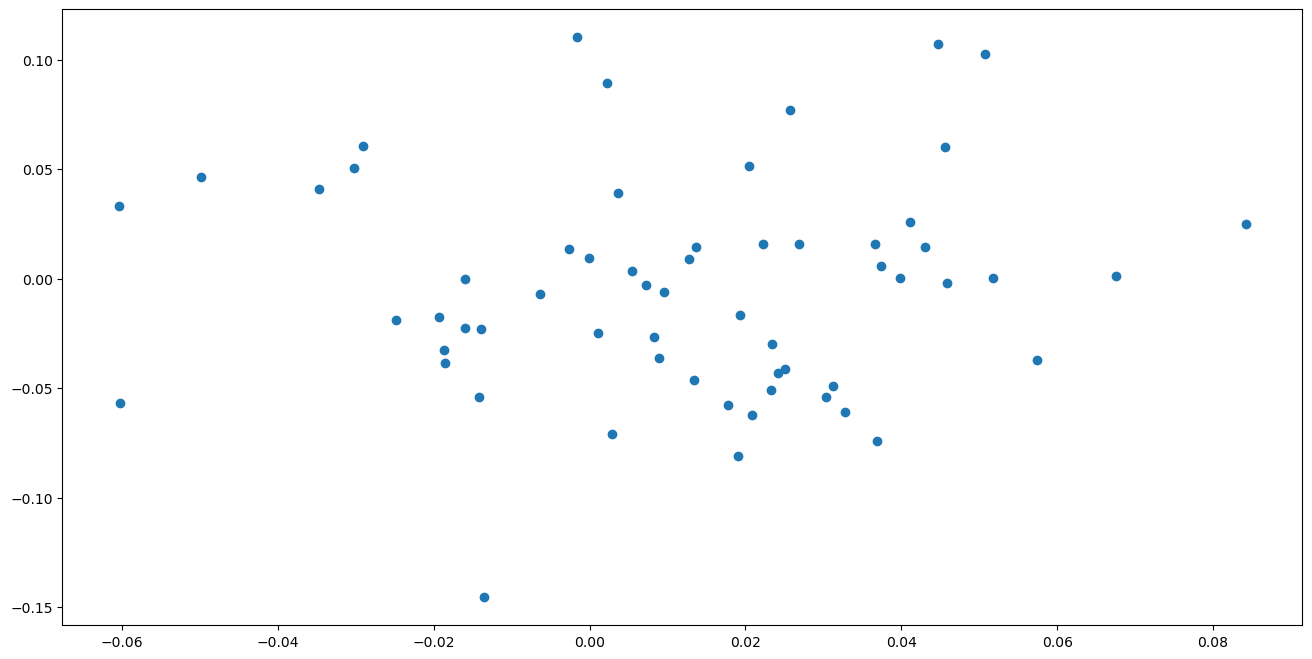

In [12]:
GLD_VFINX_scatter

## β as a correlation

β is the slope of a regression line like the prior ones.

Again, one way to interpret this number is that it measures a
relationship between the investment and the market.

- β = 2: Moves twice as far as the market, on average.
- β = 0.5: Moves half as far as the market, on average.
- The market portfolio itself has a beta of 1.
- A risk-free investment has a beta of zero.
- A risky investment can also have a beta of zero! Gold is a risky investment with approximately zero beta.

The CAPM focuses only on β, so it predicts (correctly) that gold earns low average returns despite having high volatility.

## β as non-diversifiable risk

A related interpretation is that β measures "non-diversifiable" risk.

- Gold has a low beta because its returns, while very volatile, have very little economic connection to the overall market.
- Adding gold decreases the market portfolio’s volatility (β < 1). We call this *idiosyncratic* risk or *diversifiable* risk.
- By contrast, retail stocks have a very high beta, because the performance of these stocks is closely tied to the overall market.
- When you increase holdings of retail stocks in your market portfolio, their risk reinforces the volatility you were already exposed to, and your portfolo volatility slightly increases (β > 1). We call this *market* risk, *non-diversifiable* risk, or *systematic* risk.

The CAPM says that investors only care about *non*-diversifiable risk.

Diversifiable risk does not matter to them, because it disappears when the investment is added to their portfolio.

In [13]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import wrds
import math
import numpy as np
import statsmodels.formula.api as sm

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16.0, 8.0]

import os
import sys
sys.path.append(os.path.abspath("../.."))
from utils.french_portfolios import get_French_portfolios_monthly

In [14]:
conn = wrds.Connection(wrds_username=os.environ['WRDS_USERNAME'])
FF3F = conn.get_table(library='ff_all',table='factors_monthly')
FF3F['month'] = pd.to_datetime(FF3F['date']).dt.to_period('M')
FF3F = FF3F.drop(['date','dateff','year','umd'],axis=1).set_index('month')
FF3F = FF3F['1926':'2024']
FF3F = FF3F.astype('float64')
conn.close()

Loading library list...
Done


In [15]:
def standard_figure(data):
    fig,ax = plt.subplots()
    betas = [ sm.ols("d"+str(i)+"~mktrf",data=data).fit().params[1] for i in range(1,11) ]
    avgs = [ 12*100*data["d"+str(i)].mean() for i in range(1,11)]
    plt.scatter([0,1],[0,12*100*data['mktrf'].mean()])
    plt.axline(xy1=[0,0],xy2=[1,12*100*data['mktrf'].mean()])
    plt.scatter(betas,avgs)
    plt.text(0,0,"   Risk-free",horizontalalignment="left",verticalalignment="center")
    plt.text(1,12*100*data['mktrf'].mean(),"   Market",horizontalalignment="left",verticalalignment="center")
    for i in range(1,11):
        plt.text(betas[i-1],avgs[i-1]+0.5,str(i),horizontalalignment="center",verticalalignment="bottom")
    plt.xticks([0,0.5,1,1.5,2])
    plt.yticks([-5,0,5,10,15,20])
    plt.xlabel("Beta (with respect to the market portfolio)")
    plt.ylabel("Average monthly excess return (percent, annualized)")
    return fig

## Portfolios formed on size, 1926-2024

In [16]:
%%capture

size_portfolios = get_French_portfolios_monthly("size")
size_portfolios = size_portfolios['1926':'2024']

# Calculate average excess returns and betas, and build the figure
size_portfolios_excess = {"d"+str(i): size_portfolios["d"+str(i)] - FF3F['rf'] for i in range(1,11)}
size_portfolios_excess['mktrf'] = FF3F['mktrf']
size_figure = standard_figure(size_portfolios_excess)

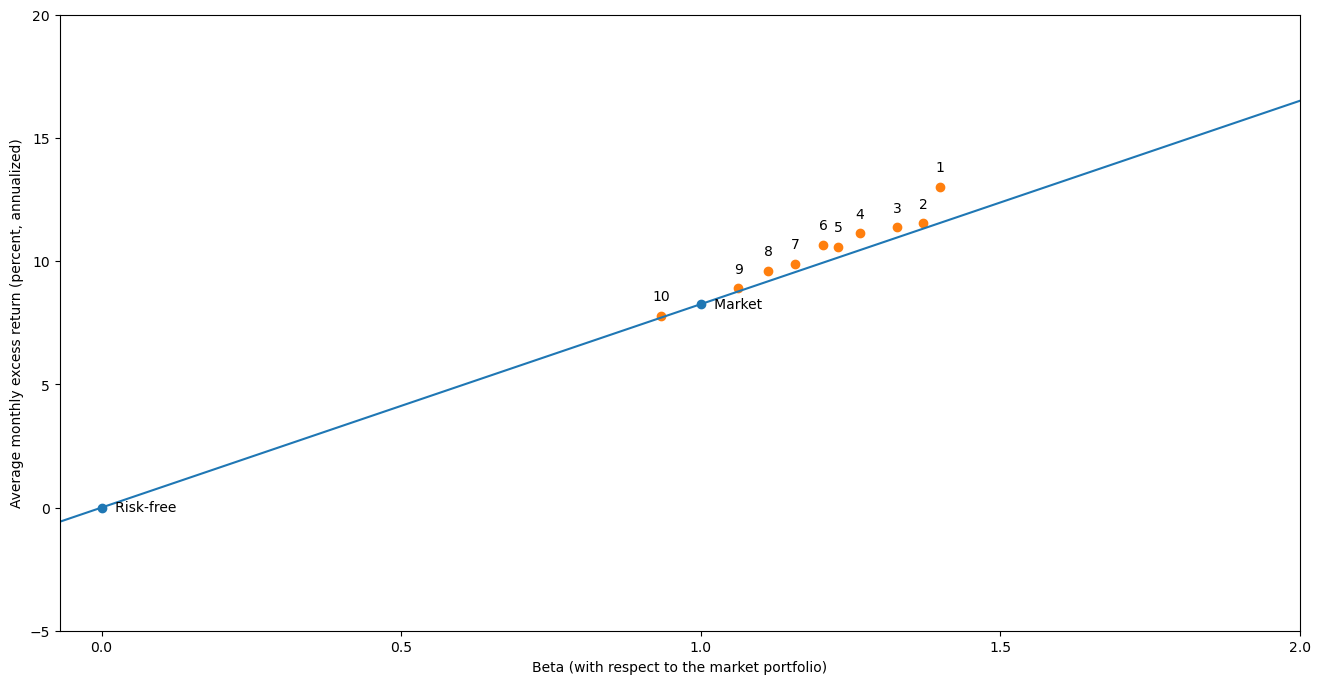

In [17]:
size_figure

## Portfolios formed on value, 1926-2024

In [18]:
%%capture

value_portfolios = get_French_portfolios_monthly("value")
value_portfolios = value_portfolios['1926':'2024']

value_portfolios_excess = {"d"+str(i): value_portfolios["d"+str(i)] - FF3F['rf'] for i in range(1,11)}
value_portfolios_excess['mktrf'] = FF3F['mktrf']
value_portfolios_figure = standard_figure(value_portfolios_excess)

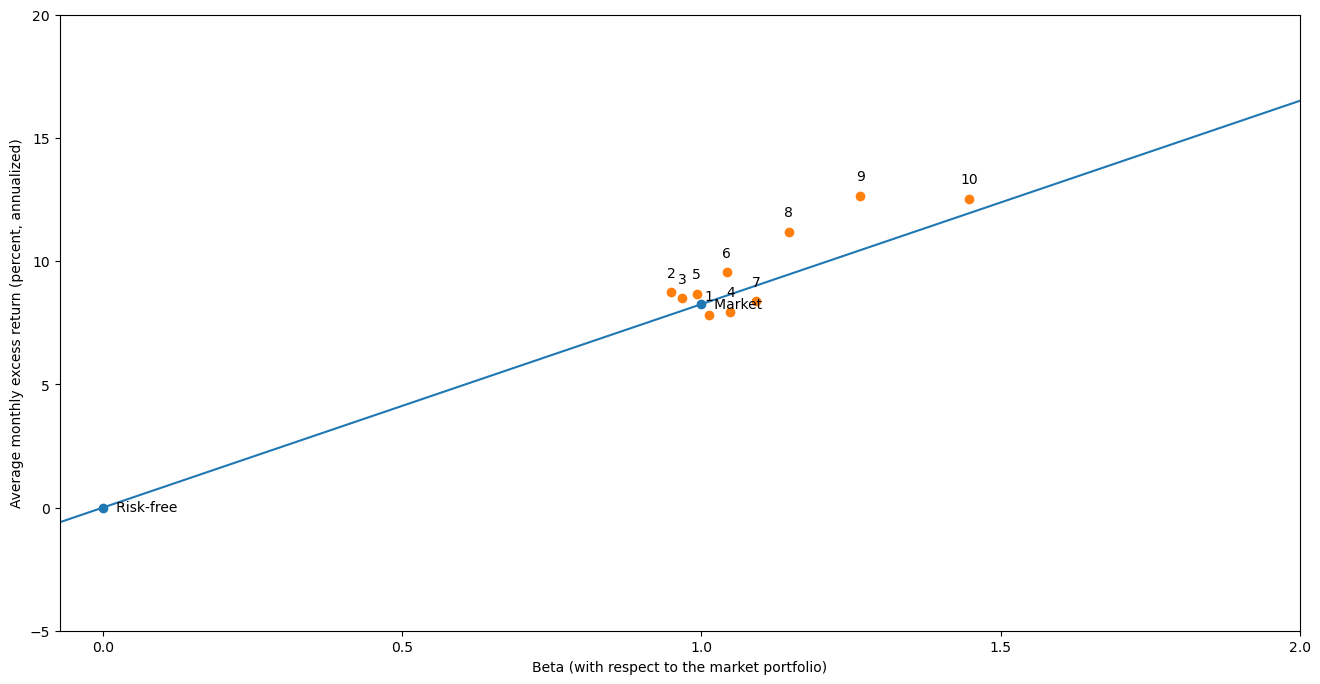

In [19]:
value_portfolios_figure

In [20]:
# # Uncomment the next block to save the data to an Excel spreadsheet for in-class example.

# try: os.remove("Value portfolios.xslx")
# except OSError: pass

# # set up custom ExcelWriter engine to get the date format correct in the output file
# writer = pd.ExcelWriter('Value portfolios.xlsx', engine='xlsxwriter', datetime_format= "yyyy-mm")

# value_portfolios.to_excel(writer,sheet_name='Portfolio returns',index_label='Month',
#                    columns=['d' + str(i) for i in range(1,11)],
#                    header=['Portfolio 1: Stocks with lowest B/M ratios (growth stocks)']
#                            +['Portfolio '+str(i) for i in range(2,10)]
#                            +['Portfolio 10: Stocks with highest B/M ratios (value stocks)'])

# FF3F.to_excel(writer,sheet_name='Risk-free and market excess',index_label='Month',
#                   columns=['mktrf','rf'],
#                   header=['Fama-French market excess return','Fama-French risk-free return'])

# writer.close()

## Notes on the historical evidence

- In these figures, size and value strategies seem to offer returns
that are roughly fair according to the CAPM. This evidence
would not encourage us to depart from a passive strategy.

- However, the early part of this sample includes the Great
Depression and the second world war. Many researchers omit
these times, and start the analysis in the 1950s.

- It’s not clear whether this is theoretically ideal or not.
In the next figures, we look at how this changes things.

## Portfolios formed on size, 1950-2024

In [21]:
%%capture
size_portfolios_excess_1950 = { key: portfolio['1950':] for key,portfolio in size_portfolios_excess.items() }
size_portfolios_figure_since_1950 = standard_figure(size_portfolios_excess_1950)

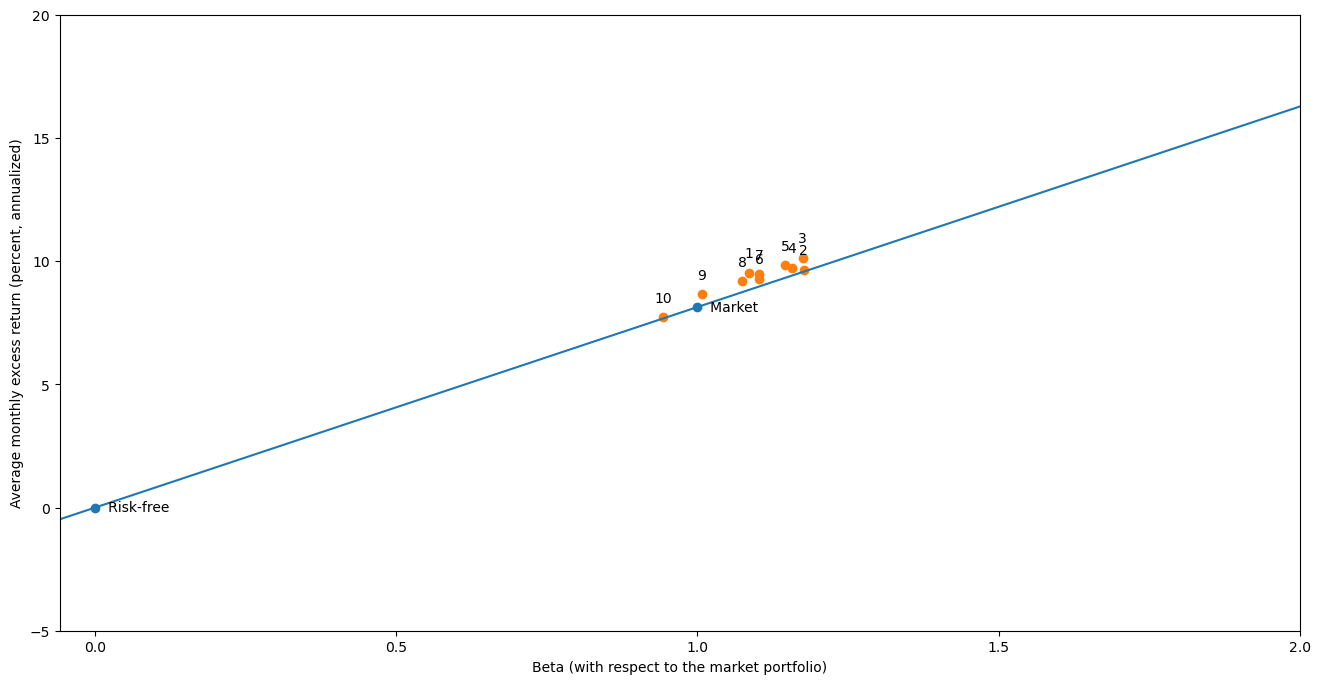

In [22]:
size_portfolios_figure_since_1950

## Portfolios formed on value, 1950-2024

In [23]:
%%capture
value_portfolios_excess_1950 = { key: portfolio['1950':] for key,portfolio in value_portfolios_excess.items() }
value_portfolios_figure_since_1950 = standard_figure(value_portfolios_excess_1950)

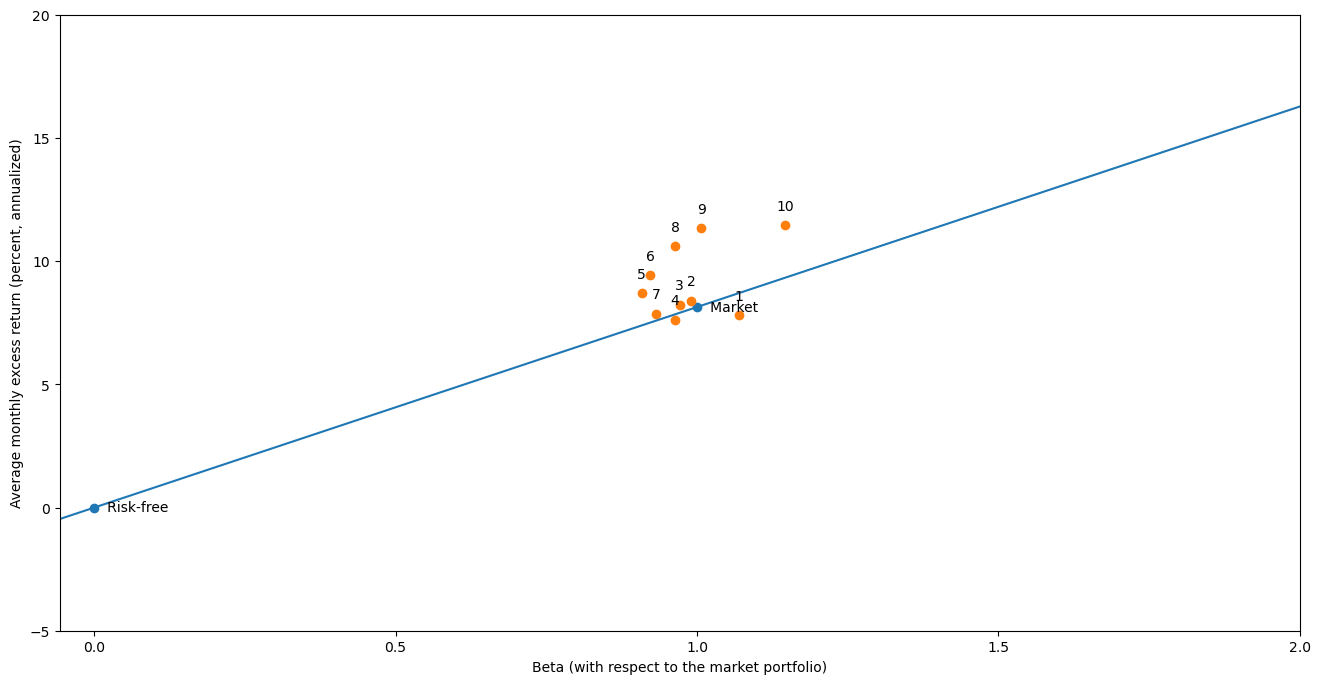

In [24]:
value_portfolios_figure_since_1950

## Notes on the figures using 1950–2024
During this shorter time period, returns to value-sorted portfolios did not follow the CAPM.

This suggests opportunities that one could have exploited.

Specifically: Value stocks (those with high BM ratios)
offered higher return, with similar beta, to growth stocks.
(Compare portfolios #8, 9, 10 with #1, 2, 3.)

This basic pattern is called the value premium.

Next: Similar conclusion for portfolios sorted on momentum.

## Portfolios formed on momentum, 1926-2024

In [25]:
%%capture

momentum_portfolios = get_French_portfolios_monthly("momentum")
momentum_portfolios = momentum_portfolios['1926':'2024']

# Calculate average excess returns and betas, and build the figure
momentum_portfolios_excess = {"d"+str(i): momentum_portfolios["d"+str(i)] - FF3F['rf'] for i in range(1,11)}
momentum_portfolios_excess['mktrf'] = FF3F['mktrf']
momentum_portfolios_figure = standard_figure(momentum_portfolios_excess)

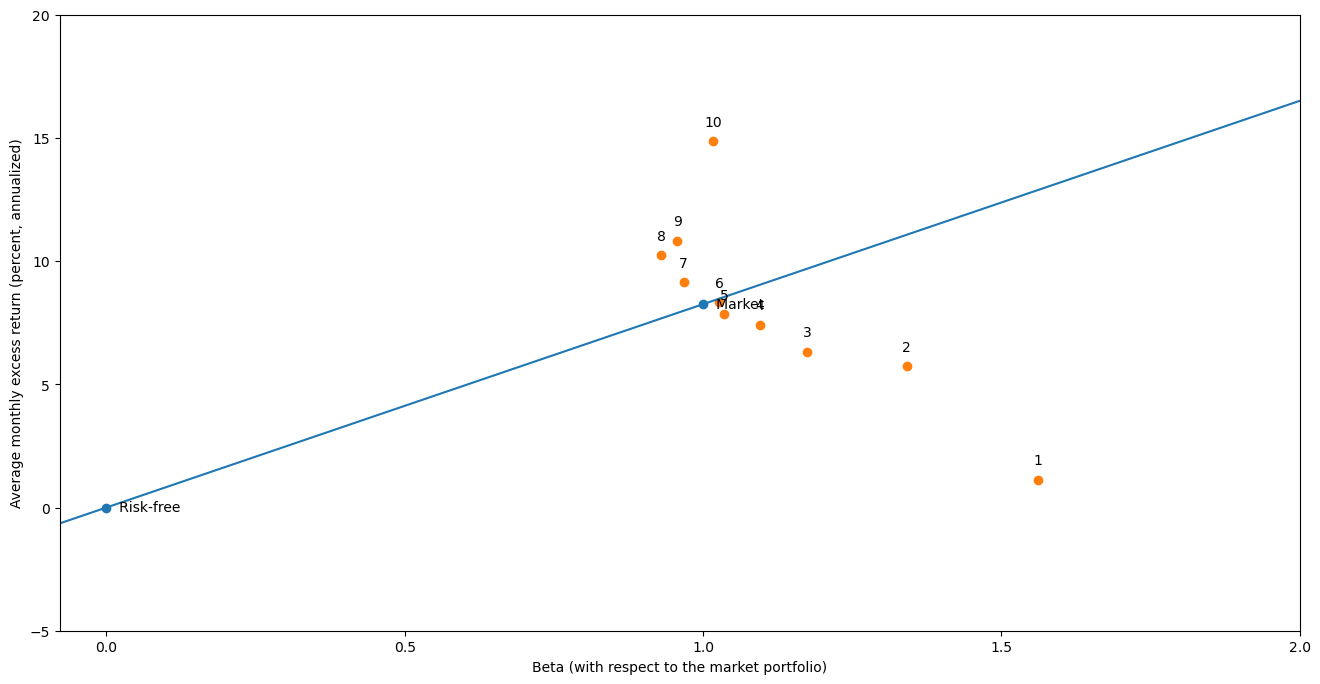

In [26]:
momentum_portfolios_figure

## Portfolios formed on momentum, 1950-2024

In [27]:
%%capture
momentum_portfolios_excess_1950 = { key: portfolio['1950':] for key,portfolio in momentum_portfolios_excess.items() }
momentum_figure_since_1950 = standard_figure(momentum_portfolios_excess_1950)

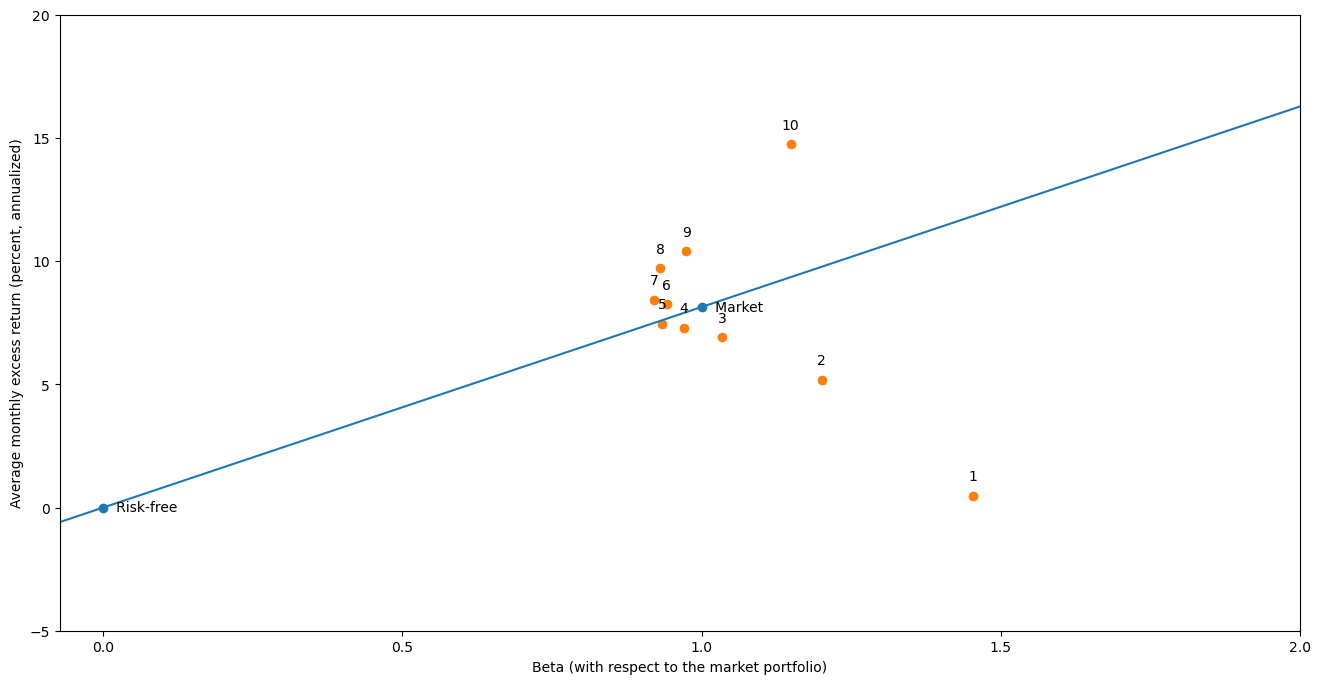

In [28]:
momentum_figure_since_1950

## Notes on value and momentum premiums

By sorting stocks on value and momentum, you could have
found portfolios in the past, that would have offered higher
returns without taking on more market risk (beta).

In academic literature, these style-based return are called factors.
I will use this term going forward.

In response to this evidence, the factor investing industry has
grown to meet investor demand for value- and
momentum-focused strategies, and to find new factors.

## Critical questions to ask about active strategies

- What kind of risk do these strategies require you to bear?
    - The figures just showed average returns and betas.
    - This does not mean you can earn steady, reliable returns.
    - In fact, to earn the averages reported in the prior figures, you had to endure many times of very poor returns.
    
- How feasible is it to implement these strategies?
    - In the past, how close could you have come to actually achieving the returns in the prior figures?
    - In the future, how reliably can you do what the strategies describe, and how expensive will that be?

## Next: Better ways to track returns on strategies

A first step is just to have a better way to track the performance of investment ideas like the ones we studied above.

- So far we’ve been focused on simple graphs of average return
against beta. But these only give us a limited perspective on the
performance of an investmen strategy.

- The biggest limitation is that these graphs just show average
performance over a long horizon. They don’t tell us how much
short-term fluctuation the strategy might exhibit relative the
long-run average.

- In Module 3, we will build indexes of investment performance
that address this issue. The basic idea will be to study the
spreads between the returns of different portfolios.

## Many ideas just repackage well-known strategies

Many popular investment ideas are tightly connected to
well-known strategies like those based on  size, value, or momentum.

- An EW index tilts heavily towards small and value stocks.
- Stocks that get added to an index are momentum stocks.

If you know this, you have a better perspective on what is really
“new,” and what is not, when you evaluate a new strategy.

- Don’t overpay for something that is already easily available!
- Again, Module 3 will explore this issue in detail.